# Gaussian Mixture Models

In [29]:
import numpy as np
import pandas as pd
import cv2 
import matplotlib.pyplot as plt
import math
import pickle
import scipy.stats as sp
import warnings
import random
import seaborn as sns
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_spd_matrix
from sklearn.metrics import confusion_matrix
from tqdm import tqdm_notebook as tqdm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [30]:
def load_train():
    train_images = []
    for i in range(105):
        path = 'Training/t' + str(i) + '.jpg'
        image = cv2.imread(path)
        train_images.append(image)
    return np.array(train_images)

In [31]:
def load_mask():
    mask_images = []
    for i in range(105):
        path = 'Testing/l' + str(i) + '.png'
        image = cv2.imread(path, 0)
        mask_images.append(image)
    return np.array(mask_images)

In [32]:
def display_img(image, mask, prediction, save=False, filename='test.png'):
    image_ = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB)
    fig = plt.figure(figsize = (15, 5)) # width x height
    ax1 = fig.add_subplot(1, 3, 1) # row, column, position
    ax2 = fig.add_subplot(1, 3, 2)
    ax3 = fig.add_subplot(1, 3, 3)
    ax1.title.set_text('Image')
    ax2.title.set_text('Mask')
    ax3.title.set_text('Prediction')
    ax1.imshow(image_)
    ax2.imshow(mask, cmap='gray')
    plt.imshow(prediction, cmap='gray')  
    ax1.axis('off')
    ax2.axis('off')
    ax3.axis('off')
    if save:
        plt.savefig(filename)
    plt.show()

In [33]:
train_images = load_train()

In [34]:
mask_images = load_mask()

In [35]:
def get_desk_coins(train_images, train_masks, color_space=cv2.COLOR_BGR2HSV):
    coin_pixels = []
    desk_pixels = []
    for i, (image, mask) in enumerate(zip(train_images, train_masks)):
        img = cv2.cvtColor(image, color_space)/1.
        # desk pixel coordinates
        y_desk, x_desk = np.where(mask < 31)
        # coin pixel coordinates
        y_coins, x_coins = np.where(mask >= 31)
        coins = img[y_coins, x_coins]
        desk = img[y_desk, x_desk]
        if i == 0:
            coin_pixels = coins
            desk_pixels = desk
        else:
            coin_pixels = np.vstack((coin_pixels, coins))
            desk_pixels = np.vstack((desk_pixels, desk))
    return coin_pixels, desk_pixels

In [36]:
class GMM:
    def __init__(self, n=3, dim=3, iterations=30, error=0.01):
        '''
        n = number of guassians to generate
        dim = dimension of image HSV
        '''
        self.n = n
        self.dim = dim
        self.means = np.zeros((self.n, self.dim))
        self.covs = np.zeros((self.n, self.dim, self.dim))
        self.iterations = iterations
        self.error = error
        self.lamdas = None

         
    def generate_random_parameters(self):
        for k in range(self.n):
            rand_cov = np.random.rand(self.dim, self.dim)*100
            self.covs[k] = np.dot(rand_cov, rand_cov.transpose())
#             rand_cov = make_spd_matrix(self.dim)*100*(i+1)
#             self.covs[i] = rand_cov.copy()
            rand_mean = np.random.randint(0, 255, self.dim)
            self.means[k] = rand_mean.copy()
        self.lamdas = np.random.dirichlet(np.ones(self.n), size=1)[0]
        lamdas = self.lamdas.copy()
        means = self.means.copy()
        covs = self.covs.copy()
        return lamdas, means, covs
    def print_stats(self):
        print('Components: ',  self.n)
        print('Lamdas: ',  self.lamdas)
        print('Means: ', self.means)
        print('Covs: ', self.covs)
    def expectation_step(self, X):
        r_i = []
        for k in range(self.n):
            if(np.linalg.det(self.covs[k]) < 0.01 or np.linalg.matrix_rank(self.covs[k]) < self.dim):
                print('Singular Error')
                rand_cov = np.random.rand(self.dim, self.dim)*1000
                self.covs[k] = np.dot(rand_cov, rand_cov.transpose())
                self.means[k] = np.random.randint(0, 255, self.dim)
            mvn_k = sp.multivariate_normal(mean=self.means[k], cov=self.covs[k]).pdf
            r_i_k = self.lamdas[k]*mvn_k(X)
            if k == 0:
                r_i = r_i_k
            else:
                r_i = np.vstack((r_i, r_i_k))
        r_i = r_i.transpose()
        r_i_k = np.divide(r_i, ((np.sum(r_i, axis=1)).reshape(r_i.shape[0], 1)))
        self.r_i_k = r_i_k.copy()
    def maximization_step(self, X):
        for k in range(self.n):
            self.lamdas[k] = np.sum(self.r_i_k[:, k])/np.sum(self.r_i_k[:, :])
            self.means[k] = np.dot(self.r_i_k[:, k], X)/np.sum(self.r_i_k[:, k])
            data = X - self.means[k]
            data_t = data.transpose()
            self.covs[k] = (np.dot(data_t, (np.multiply(data, (self.r_i_k[:, k].reshape((self.r_i_k.shape[0], 1)))))))/np.sum(self.r_i_k[:, k])
        lamdas = self.lamdas.copy()
        means = self.means.copy()
        covs = self.covs.copy()
        return lamdas, means, covs  
    def run_algorithm(self, X):
        if self.n > 1:
            p_l, p_m, p_c = self.generate_random_parameters()
            p_l_e, p_m_e, p_c_e = 0, 0, 0
            for i in tqdm(range(self.iterations)):
                self.expectation_step(X)
                l, m, c = self.maximization_step(X)
                lamda_error = np.max(np.abs(p_l - l))
                mean_error = np.max(np.abs(p_m - m))
                cov_error = np.max(np.abs(p_c - c))
                l_e = np.abs(lamda_error-p_l_e)
                m_e = np.abs(mean_error-p_m_e)
                c_e = np.abs(cov_error-p_c_e)
                if c_e < self.error and l_e < self.error and m_e < self.error:
                    break
                p_l, p_m, p_c = l.copy(), m.copy(), c.copy()
                p_l_e, p_m_e, p_c_e = lamda_error, mean_error, cov_error
        else:
            self.means = np.mean(X, axis=0)
            self.covs = np.cov(X, rowvar=False)

In [37]:
def get_metrics(y, y_hat):
    I = y.shape[0] * y.shape[1]
    y = y.reshape((I, 1))
    y_hat = y_hat.reshape((I, 1))
    y[y <= 31] = 0
    y[y > 31] = 1
    y_hat[y_hat <= 31] = 0
    y_hat[y_hat > 31] = 1
    cm = confusion_matrix(y, y_hat)
    accuracy = np.sum(np.diag(cm))/np.sum(cm)
    precision = cm[1, 1]/(cm[1, 1]+cm[1, 0])
    recall = cm[1, 1]/(cm[1, 1] + cm[0, 1])
    f1_score = 2*(precision*recall)/(precision+recall)
    return [accuracy, precision, recall, f1_score] 

## Training

In [38]:
def training(train_images, mask_images):
    train_length = [3, 4, 8, 10, 12, 15, 29, 35, 40, 41, 45, 48, 49, 51, 76, 77, 78, 84, 85, 86]
    train = np.array(train_length, dtype=np.int)
    gmm_coins = GMM()
    gmm_desk = GMM()
    GMM_c = []
    GMM_d = []
    for j in tqdm(range(1, 11)):
        print(j)
        n_guassians_coin = j
        n_guassians_desk = j  
        color_space = cv2.COLOR_BGR2HSV
        coins, desk = get_desk_coins(train_images[train].copy(), mask_images[train].copy(), color_space=color_space)
        lamda = coins.shape[0]/(desk.shape[0]+coins.shape[0])
        gmm_coins = GMM(n=n_guassians_coin, dim=3, iterations=50, error=1)
        gmm_coins.run_algorithm(coins)
        gmm_desk = GMM(n=n_guassians_desk, dim=3, iterations=25, error=1)
        gmm_desk.run_algorithm(desk)
        gmm_coins.r_i_k = 0
        gmm_desk.r_i_k = 0
        GMM_c.append(gmm_coins)
        GMM_d.append(gmm_desk)
        gmm_coins.print_stats()
        gmm_desk.print_stats()
    return GMM_c, GMM_d

In [39]:
# GMM_c, GMM_d = training(train_images.copy(), mask_images.copy())

In [40]:
# with open('GMM_c.pkl', 'wb') as f:
#     pickle.dump(GMM_c, f)
# with open('GMM_d.pkl', 'wb') as f:
#     pickle.dump(GMM_d, f)        

## Testing

### Reading in pickled GMM models that have been trained.

In [41]:
with open('GMM_c.pkl', 'rb') as f:
    GMM_c = pickle.load(f)
with open('GMM_d.pkl', 'rb') as f:
    GMM_d = pickle.load(f)

In [42]:
def make_prediction(test_image, mask_image, gmm_coins, gmm_desk, lamda, color_space=cv2.COLOR_BGR2HSV):
    l_coin = []
    l_desk = []
    test_image_hsv = cv2.cvtColor(test_image, color_space)
    test_image_ = test_image_hsv.reshape((test_image.shape[0]*test_image.shape[1], 3))
    posterior = np.zeros((test_image.shape[0]*test_image.shape[1]))
    if gmm_coins.n > 1 and gmm_desk.n > 1:
        for k in range(gmm_coins.n):
            m_coin = sp.multivariate_normal(mean=gmm_coins.means[k], cov=gmm_coins.covs[k]).pdf
            k_l_coin = m_coin(test_image_)
            if k == 0:
                l_coin = k_l_coin
            else:
                l_coin = np.vstack((l_coin, k_l_coin))
        for k in range(gmm_desk.n):
            m_desk = sp.multivariate_normal(mean=gmm_desk.means[k], cov=gmm_desk.covs[k]).pdf
            k_l_desk = m_desk(test_image_)
            if k == 0:
                l_desk = k_l_desk
            else:
                l_desk = np.vstack((l_desk, k_l_desk))
        l_coin = l_coin.transpose()
        l_desk = l_desk.transpose()
        coin_likelihood = np.dot(l_coin, gmm_coins.lamdas)
        desk_likelihood = np.dot(l_desk, gmm_desk.lamdas)
    elif gmm_coins.n > 1 and gmm_desk.n == 1:
        for k in range(gmm_coins.n):
            m_coin = sp.multivariate_normal(mean=gmm_coins.means[k], cov=gmm_coins.covs[k]).pdf
            k_l_coin = m_coin(test_image_)
            if k == 0:
                l_coin = k_l_coin
            else:
                l_coin = np.vstack((l_coin, k_l_coin))
        l_coin = l_coin.transpose()
        coin_likelihood = np.dot(l_coin, gmm_coins.lamdas)
        
        l_desk = sp.multivariate_normal(mean=gmm_desk.means, cov=gmm_desk.covs).pdf
        desk_likelihood = l_desk(test_image_)
    elif gmm_coins.n == 1 and gmm_desk.n > 1:
        for k in range(gmm_desk.n):
            m_desk = sp.multivariate_normal(mean=gmm_desk.means[k], cov=gmm_desk.covs[k]).pdf
            k_l_desk = m_desk(test_image_)
            if k == 0:
                l_desk = k_l_desk
            else:
                l_desk = np.vstack((l_desk, k_l_desk))
        l_desk = l_desk.transpose()
        desk_likelihood = np.dot(l_desk, gmm_desk.lamdas)
        l_coin = sp.multivariate_normal(mean=gmm_coins.means, cov=gmm_coins.covs).pdf
        coin_likelihood = l_coin(test_image_)
    elif gmm_coins.n == 1 and gmm_desk.n == 1:
        l_coin = sp.multivariate_normal(mean=gmm_coins.means, cov=gmm_coins.covs).pdf
        l_desk = sp.multivariate_normal(mean=gmm_desk.means, cov=gmm_desk.covs).pdf
        coin_likelihood = l_coin(test_image_)
        desk_likelihood = l_desk(test_image_)
        
    posterior = (coin_likelihood*lamda)/((lamda*coin_likelihood)+((1-lamda)*desk_likelihood))
    posterior[posterior > 0.5] = 255.0
    posterior[posterior <= 0.5] = 0.0
    posterior = posterior.reshape((test_image.shape[0], test_image.shape[1]))
    return posterior.copy()

In [43]:
def testing(train_images, mask_images, GMM_c, GMM_d, test_size=15):
    num_images = np.linspace(0, 104, 105)
    train_length = [3, 4, 8, 10, 12, 15, 29, 30, 35, 40, 41, 45, 48, 49, 51, 76, 77, 78, 84, 85, 86]
    train = np.array(train_length, dtype=np.int)
    test = np.random.choice(np.array(list(set(list(num_images)) - set(list(train))), dtype=np.int), test_size)
    # test = np.array(list(set(list(num_images)) - set(list(train))), dtype=np.int)
    metrics = []
    shape = train_images[0].shape
    color_space = cv2.COLOR_BGR2HSV
    coins, desk = get_desk_coins(train_images[train].copy(), mask_images[train].copy(), color_space=color_space)
    lamda = coins.shape[0]/(desk.shape[0]+coins.shape[0])
    for c in tqdm(range(len(GMM_c))):
        m = []
        gmm_coins = GMM_c[c]
        for d in tqdm(range(len(GMM_d))):
            predicted_masks = np.empty((shape[0], shape[1]*test_size))
            true_masks = np.empty((shape[0], shape[1]*test_size))
            gmm_desk = GMM_d[d]
            for i, img in enumerate(test):
                predicted_masks[:, shape[1]*(i):shape[1]*(i+1)] = make_prediction(train_images[img], mask_images[img], gmm_coins, gmm_desk, lamda, color_space=color_space)
                true_masks[:, shape[1]*(i):shape[1]*(i+1)] = mask_images[img]
#                 if i == 0:
#                     predicted_masks = make_prediction(train_images[img], mask_images[img], gmm_coins, gmm_desk, lamda, color_space=color_space)
#                     true_masks = mask_images[img]
#                 else:
#                     predicted_masks = np.concatenate((predicted_masks, make_prediction(train_images[img], mask_images[img], gmm_coins, gmm_desk, lamda, color_space=color_space)), axis=1)
#                     true_masks = np.concatenate((true_masks, mask_images[img]), axis=1)
            m.append(get_metrics(true_masks, predicted_masks))
        metrics.append(m)
    return metrics

In [44]:
# metrics = testing(train_images.copy(), mask_images.copy(), GMM_c.copy(), GMM_d.copy(), test_size=15)

In [45]:
# with open('metrics.pkl', 'wb') as f:
#     pickle.dump(metrics, f)

In [46]:
with open('metrics.pkl', 'rb') as f:
    metrics = pickle.load(f)

In [19]:
acc = np.array([np.sum(metrics[j][i][0]) for j in range(len(metrics)) for i in range(len(metrics[0]))])
acc = acc.reshape((10, 10))*100
acc = np.around(acc, decimals=3)

In [20]:
np.argmax(acc)

6

In [21]:
np. argmin(acc)

50

In [22]:
acc

array([[98.405, 98.663, 98.459, 98.713, 98.629, 98.705, 98.923, 98.406,
        98.733, 98.625],
       [98.088, 98.214, 98.431, 98.502, 98.65 , 98.629, 98.857, 98.58 ,
        98.679, 98.63 ],
       [98.093, 98.201, 98.422, 98.366, 98.602, 98.583, 98.855, 98.481,
        98.648, 98.609],
       [98.075, 98.145, 98.386, 98.363, 98.628, 98.594, 98.866, 98.462,
        98.582, 98.605],
       [98.065, 98.098, 98.255, 98.361, 98.5  , 98.575, 98.806, 98.473,
        98.539, 98.528],
       [98.016, 98.151, 98.371, 98.481, 98.637, 98.659, 98.901, 98.596,
        98.701, 98.6  ],
       [98.091, 98.184, 98.342, 98.472, 98.61 , 98.651, 98.871, 98.542,
        98.665, 98.558],
       [98.077, 98.203, 98.314, 98.503, 98.61 , 98.63 , 98.861, 98.579,
        98.687, 98.582],
       [98.11 , 98.229, 98.319, 98.471, 98.612, 98.627, 98.859, 98.531,
        98.656, 98.558],
       [98.11 , 98.272, 98.416, 98.487, 98.663, 98.652, 98.916, 98.525,
        98.719, 98.598]])

In [23]:
acc_df = pd.DataFrame(acc, index=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'], columns=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
acc_df.columns.names = ['K']
print(acc_df.to_latex())

\begin{tabular}{lrrrrrrrrrr}
\toprule
K &       1 &       2 &       3 &       4 &       5 &       6 &       7 &       8 &       9 &      10 \\
\midrule
1  &  98.405 &  98.663 &  98.459 &  98.713 &  98.629 &  98.705 &  98.923 &  98.406 &  98.733 &  98.625 \\
2  &  98.088 &  98.214 &  98.431 &  98.502 &  98.650 &  98.629 &  98.857 &  98.580 &  98.679 &  98.630 \\
3  &  98.093 &  98.201 &  98.422 &  98.366 &  98.602 &  98.583 &  98.855 &  98.481 &  98.648 &  98.609 \\
4  &  98.075 &  98.145 &  98.386 &  98.363 &  98.628 &  98.594 &  98.866 &  98.462 &  98.582 &  98.605 \\
5  &  98.065 &  98.098 &  98.255 &  98.361 &  98.500 &  98.575 &  98.806 &  98.473 &  98.539 &  98.528 \\
6  &  98.016 &  98.151 &  98.371 &  98.481 &  98.637 &  98.659 &  98.901 &  98.596 &  98.701 &  98.600 \\
7  &  98.091 &  98.184 &  98.342 &  98.472 &  98.610 &  98.651 &  98.871 &  98.542 &  98.665 &  98.558 \\
8  &  98.077 &  98.203 &  98.314 &  98.503 &  98.610 &  98.630 &  98.861 &  98.579 &  98.687 &  98.582 \\


In [24]:
f1 = np.array([np.sum(metrics[j][i][3]) for j in range(len(metrics)) for i in range(len(metrics[0]))])
f1 = f1.reshape((10, 10))*100
f1 = np.around(f1, decimals=3)

In [25]:
f1_df = pd.DataFrame(f1, index=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'], columns=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
f1_df.columns.names = ['K']
print(f1_df.to_latex())

\begin{tabular}{lrrrrrrrrrr}
\toprule
K &       1 &       2 &       3 &       4 &       5 &       6 &       7 &       8 &       9 &      10 \\
\midrule
1  &  79.004 &  82.894 &  80.380 &  83.240 &  82.240 &  81.966 &  85.702 &  77.636 &  83.251 &  82.515 \\
2  &  76.834 &  79.376 &  80.558 &  81.498 &  82.885 &  81.688 &  85.214 &  81.119 &  83.099 &  83.022 \\
3  &  76.627 &  78.599 &  80.386 &  79.447 &  82.299 &  80.364 &  84.892 &  79.584 &  82.326 &  82.877 \\
4  &  76.465 &  78.090 &  80.216 &  79.512 &  82.755 &  80.602 &  85.157 &  79.332 &  81.632 &  82.926 \\
5  &  76.359 &  77.923 &  78.526 &  79.709 &  81.047 &  80.532 &  84.303 &  79.825 &  81.364 &  82.032 \\
6  &  76.283 &  79.304 &  80.414 &  81.800 &  83.246 &  82.461 &  86.135 &  81.903 &  83.871 &  83.126 \\
7  &  77.021 &  79.507 &  80.152 &  81.692 &  82.943 &  82.448 &  85.771 &  81.398 &  83.474 &  82.688 \\
8  &  76.976 &  79.759 &  79.901 &  82.031 &  82.980 &  82.281 &  85.707 &  81.843 &  83.767 &  82.897 \\


In [26]:
np.argmax(f1)

56

In [27]:
np.argmin(f1)

50

In [28]:
def evaluate_components(GMM_c, k=0):
    means = []
    stddevs = []
    weights = []
    for i in range(0, len(GMM_c)):
        gmm = GMM_c[i]
        m = []
        std = []
        w = []
        for j in range(gmm.n):
            if gmm.n == 1:
                m.append(gmm.means[k])
                std.append(np.sqrt(gmm.covs[k, k]))
                w.append(1)
            else:
                m.append(gmm.means[j, k])
                std.append(gmm.covs[j, k, k])
                w.append(gmm.lamdas[j])
        means.append(m)
        stddevs.append(std)
        weights.append(w)     
    return means, stddevs, weights

In [23]:
def plot_hists(GMM, array, name='coins', save=True, color='b', lw=3):
    h_m, h_s, h_w = evaluate_components(GMM, 0)
    s_m, s_s, s_w = evaluate_components(GMM, 1)
    v_m, v_s, v_w = evaluate_components(GMM, 2)    
    x = np.linspace(0, 255, 256)

    for i in range(len(h_m)):
        filename = name + str(i) + '.png'
        means_1, means_2, means_3 = h_m[i], s_m[i], v_m[i]
        stds_1, stds_2, stds_3 = h_s[i], s_s[i], v_s[i]
        weights_1, weights_2, weights_3 = h_w[i], s_w[i], v_w[i]
        x = np.linspace(0, 255, 256)
        pdfs_1 = [p * sp.norm.pdf(x, mu, np.sqrt(sd)) for mu, sd, p in zip(means_1, stds_1, weights_1)]
        pdfs_2 = [p * sp.norm.pdf(x, mu, np.sqrt(sd)) for mu, sd, p in zip(means_2, stds_2, weights_2)]
        pdfs_3 = [p * sp.norm.pdf(x, mu, np.sqrt(sd)) for mu, sd, p in zip(means_3, stds_3, weights_3)]
        fig = plt.figure(figsize = (12, 3)) # width x height
        ax1 = fig.add_subplot(1, 3, 1) # row, column, position
        ax2 = fig.add_subplot(1, 3, 2)
        ax3 = fig.add_subplot(1, 3, 3)
        pixels_h = np.reshape(array[:, 0].copy(), array.shape[0])
        pixels_s = np.reshape(array[:, 1].copy(), array.shape[0])
        pixels_v = np.reshape(array[:, 2].copy(), array.shape[0])
        sns.distplot(pixels_h, hist=False, color='k', ax=ax1, label='Training Hue', kde_kws=dict(linewidth=lw))
        sns.distplot(pixels_s, hist=False, color='k', ax=ax2, label='Training Saturation', kde_kws=dict(linewidth=lw))
        sns.distplot(pixels_v, hist=False, color='k', ax=ax3, label='Training Value', kde_kws=dict(linewidth=lw))
        
        ax1.title.set_text('Hue '+str(name)+ ' Pixels with K = '+ str(i+1))
        ax2.title.set_text('Saturation '+str(name)+ ' Pixels with K = '+ str(i+1))
        ax3.title.set_text('Value '+str(name)+ ' Pixels with K = '+ str(i+1))
        
        density_1 = np.sum(np.array(pdfs_1), axis=0)
        density_2 = np.sum(np.array(pdfs_2), axis=0)
        density_3 = np.sum(np.array(pdfs_3), axis=0)
        sns.lineplot(x=x, y=density_1, ax=ax1, label='GMM Hue', c=color, linewidth=2)
        sns.lineplot(x=x, y=density_2, ax=ax2, label='GMM Saturation', c=color, linewidth=2)
        sns.lineplot(x=x, y=density_3, ax=ax3, label='GMM Value', c=color, linewidth=2)
        
#         ax1.axis('off')
#         ax2.axis('off')
#         ax3.axis('off')
        if save:
            plt.savefig(filename)
        plt.show()

In [24]:
train_length = [3, 4, 8, 10, 12, 15, 29, 30, 35, 40, 41, 45, 48, 49, 51, 76, 77, 78, 84, 85, 86]
train = np.array(train_length, dtype=np.int)
color_space = cv2.COLOR_BGR2HSV
coins, desk = get_desk_coins(train_images[train].copy(), mask_images[train].copy(), color_space=color_space)

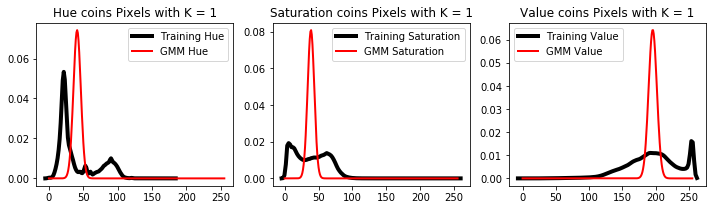

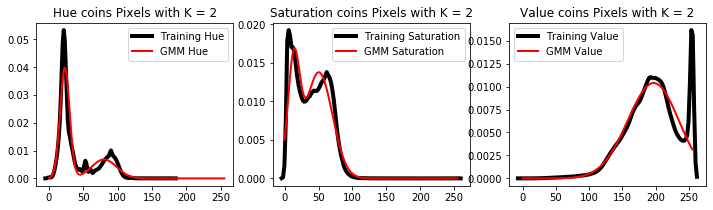

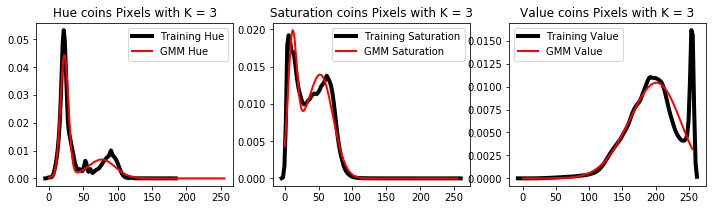

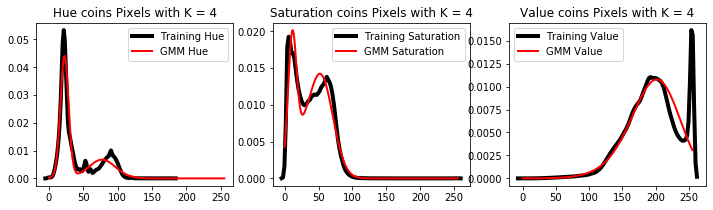

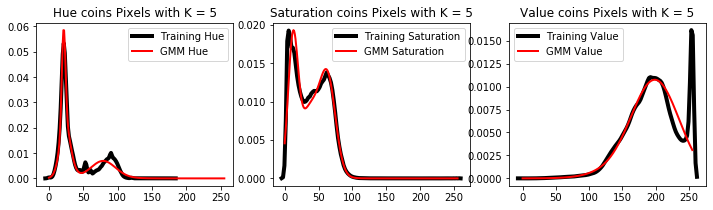

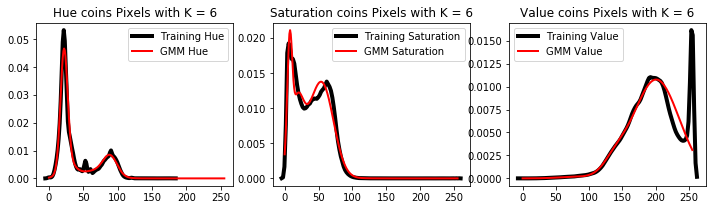

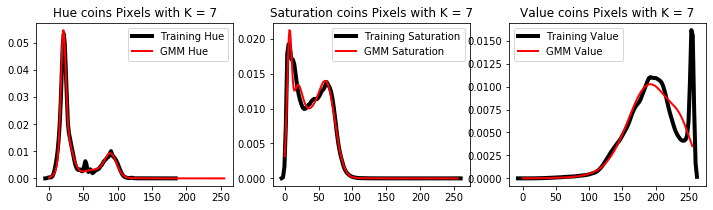

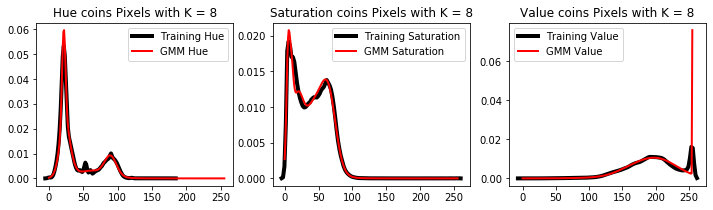

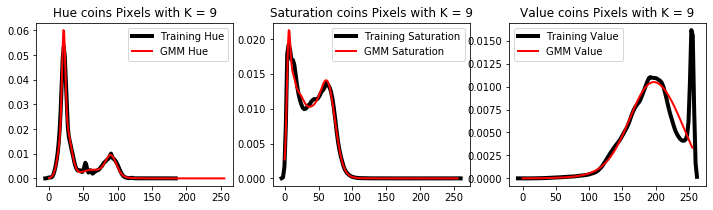

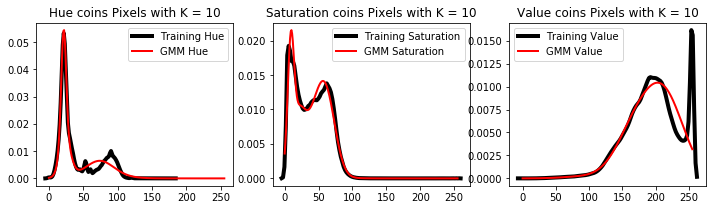

In [25]:
plot_hists(GMM_c, coins, name='coins', color='r', lw=4)

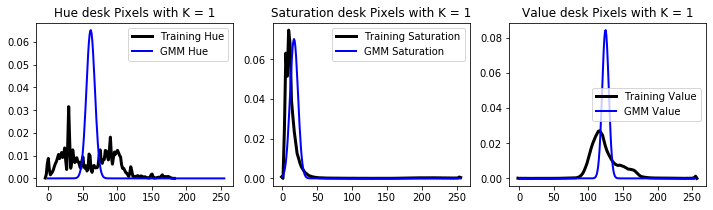

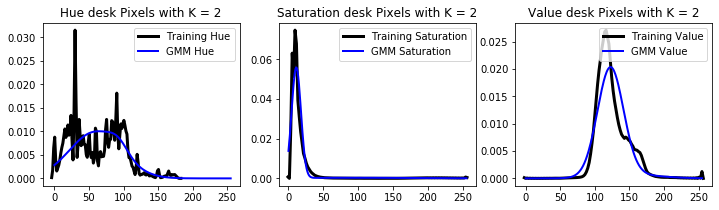

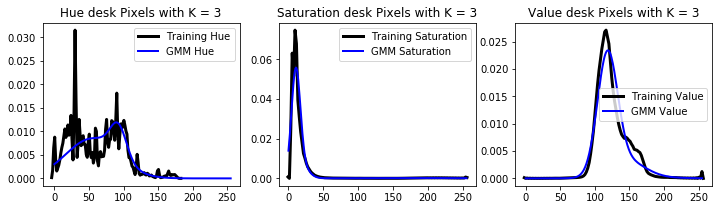

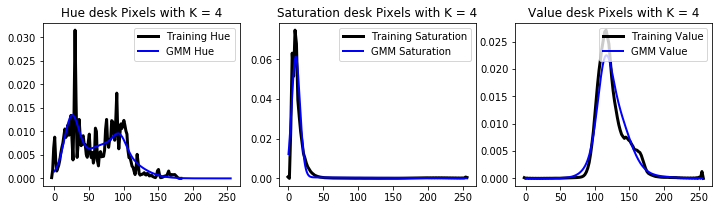

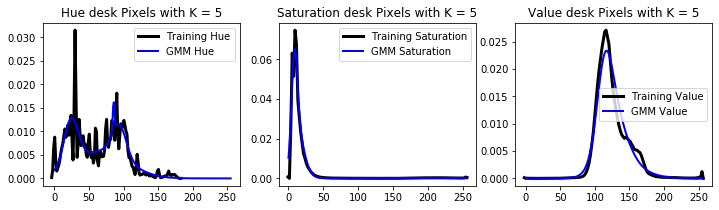

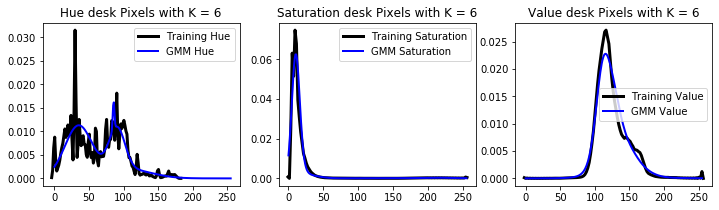

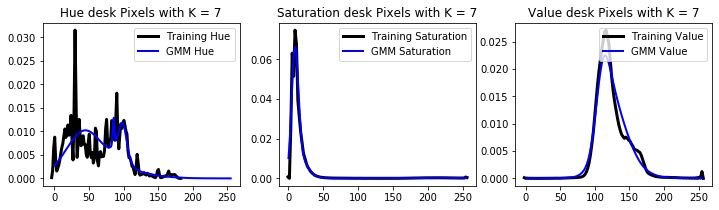

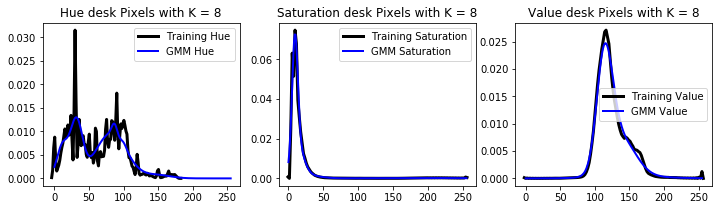

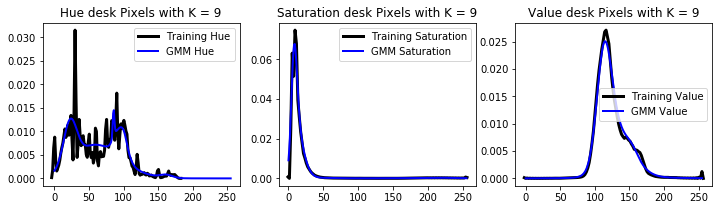

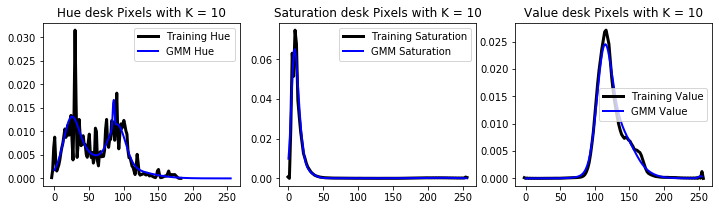

In [26]:
plot_hists(GMM_d, desk, name='desk', color='b', lw=3)

In [29]:
def plot_hue(GMM_c, GMM_d, coins, desk, name='coins_desk', save=True):
    h_m_c, h_s_c, h_w_c = evaluate_components(GMM_c, 0)
    h_m_d, h_s_d, h_w_d = evaluate_components(GMM_d, 0)    
    x = np.linspace(0, 255, 256)
    lw = 3

    for i in range(len(h_m_c)):
        filename = name + str(i) + '.png'
        means_1, means_2, = h_m_c[i], h_m_d[i]
        stds_1, stds_2 = h_s_c[i], h_s_d[i]
        weights_1, weights_2 = h_w_c[i], h_w_d[i]
        x = np.linspace(0, 255, 256)
        pdfs_1 = [p * sp.norm.pdf(x, mu, np.sqrt(sd)) for mu, sd, p in zip(means_1, stds_1, weights_1)]
        pdfs_2 = [p * sp.norm.pdf(x, mu, np.sqrt(sd)) for mu, sd, p in zip(means_2, stds_2, weights_2)]
        fig = plt.figure(figsize = (10, 4)) # width x height
        ax1 = fig.add_subplot(1, 2, 1) # row, column, position
        ax2 = fig.add_subplot(1, 2, 2)
#         ax3 = fig.add_subplot(1, 3, 3)
        pixels_h_c = np.reshape(coins[:, 0].copy(), coins.shape[0])
        pixels_h_d = np.reshape(desk[:, 0].copy(), desk.shape[0])
    
        sns.distplot(pixels_h_c, hist=False, color='k', ax=ax1, label='Training Hue Coins', kde_kws=dict(linewidth=lw))
        sns.distplot(pixels_h_d, hist=False, color='k', ax=ax2, label='Training Hue Desk', kde_kws=dict(linewidth=lw))
        
        ax1.title.set_text('Hue Coins Pixels with K = '+ str(i+1))
        ax2.title.set_text('Hue Desk Pixels with K = '+ str(i+1))
        
        density_1 = np.sum(np.array(pdfs_1), axis=0)
        density_2 = np.sum(np.array(pdfs_2), axis=0)
        sns.lineplot(x=x, y=density_1, ax=ax1, label='GMM Coins Hue', c='r')
        sns.lineplot(x=x, y=density_2, ax=ax2, label='GMM Desk Hue', c='b')
        
#         ax1.axis('off')
#         ax2.axis('off')
#         ax3.axis('off')
        if save:
            plt.savefig(filename)
        plt.show()

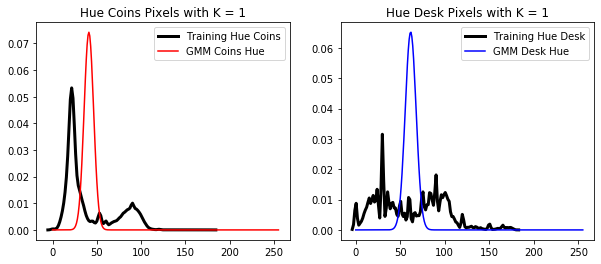

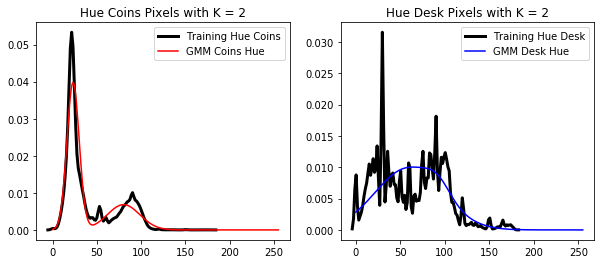

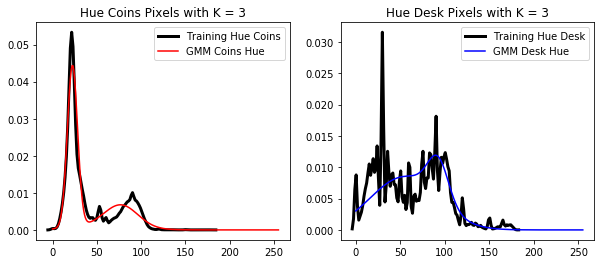

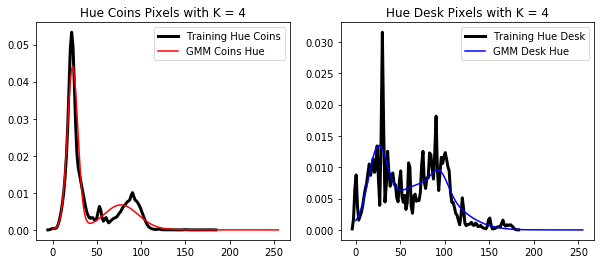

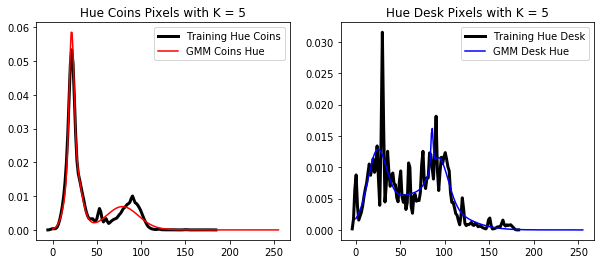

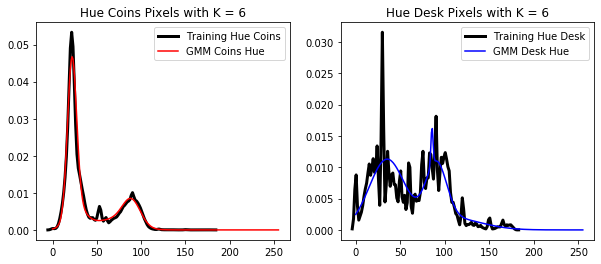

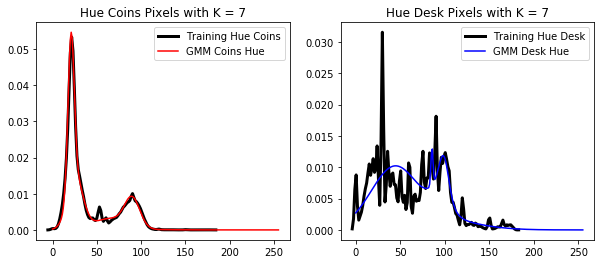

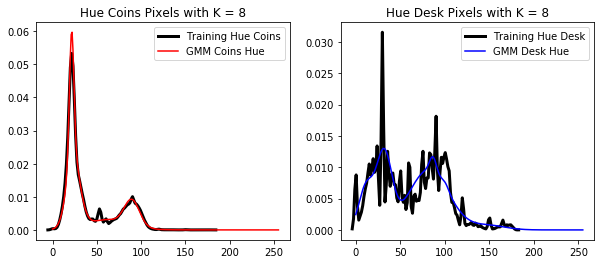

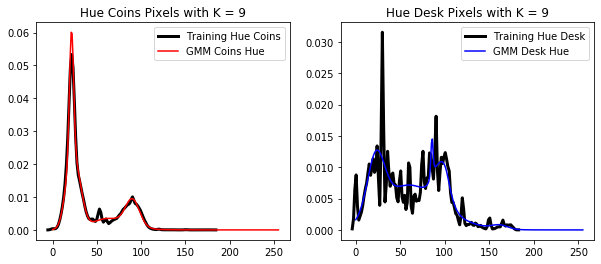

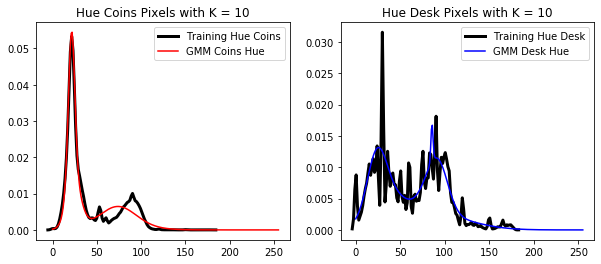

In [30]:
plot_hue(GMM_c, GMM_d, coins, desk)

In [30]:
def test_(train_images, mask_images, gmm_c, gmm_d, gmm_c_w, gmm_d_w, test_size=15):
    num_images = np.linspace(0, 104, 105)
    train_length = [3, 4, 8, 10, 12, 15, 29, 30, 35, 40, 41, 45, 48, 49, 51, 76, 77, 78, 84, 85, 86]
    train = np.array(train_length, dtype=np.int)
    ex = np.array(list(set(list(num_images)) - set(list(train))), dtype=int)
    np.random.shuffle(ex)
    test = np.random.choice(train_length, test_size)
    metrics = []
    shape = train_images[0].shape
    color_space = cv2.COLOR_BGR2HSV
    coins, desk = get_desk_coins(train_images[train].copy(), mask_images[train].copy(), color_space=color_space)
    lamda = coins.shape[0]/(desk.shape[0]+coins.shape[0])
    for i, img in enumerate(test):
        filename = 'GMM_coins_' + str(gmm_c.n) + '_desk_' + str(gmm_d.n) + '_' + str(i) + '.png' 
        display_img(train_images[img], mask_images[img], make_prediction(train_images[img], mask_images[img], gmm_c, gmm_d, lamda, color_space=color_space), save=True, filename=filename)
        filename = 'GMM_coins_' + str(gmm_c_w.n) + '_desk_' + str(gmm_d_w.n) + '_' + str(i) + '_w.png' 
        display_img(train_images[img], mask_images[img], make_prediction(train_images[img], mask_images[img], gmm_c_w, gmm_d_w, lamda, color_space=color_space), save=True, filename=filename)

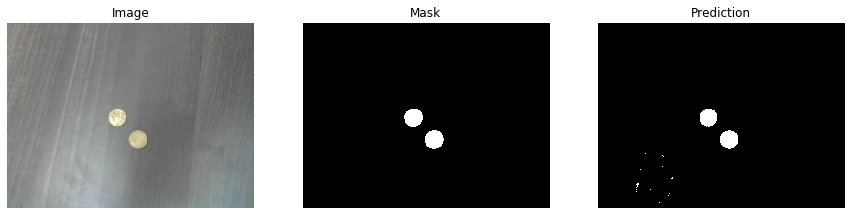

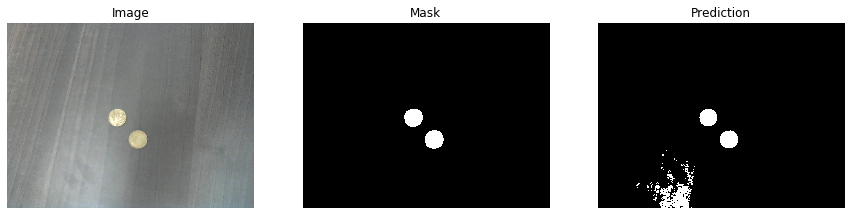

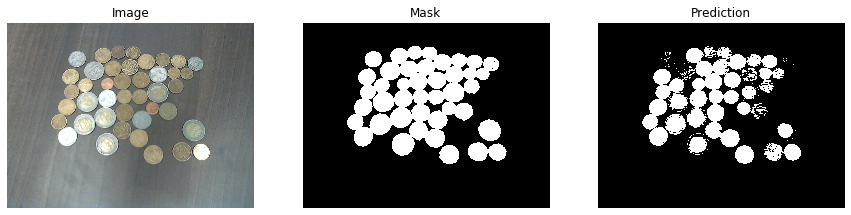

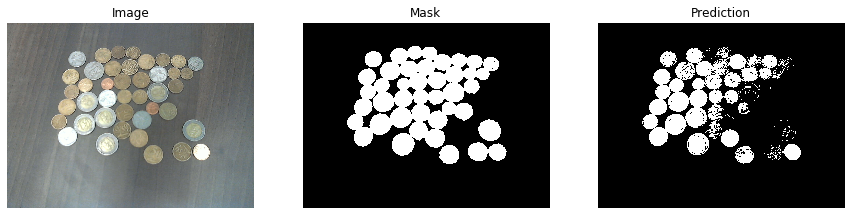

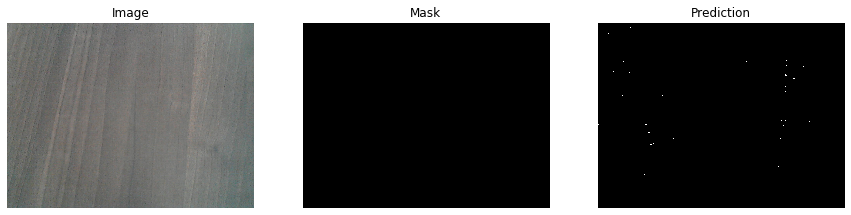

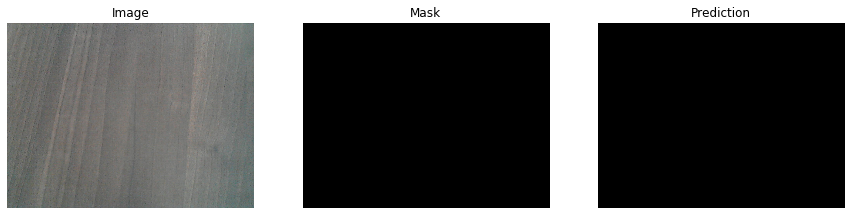

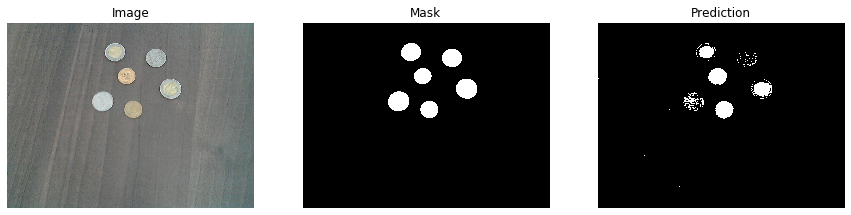

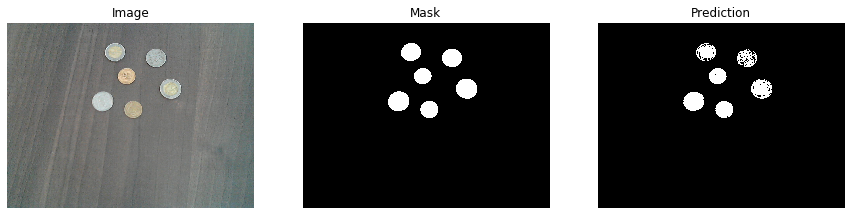

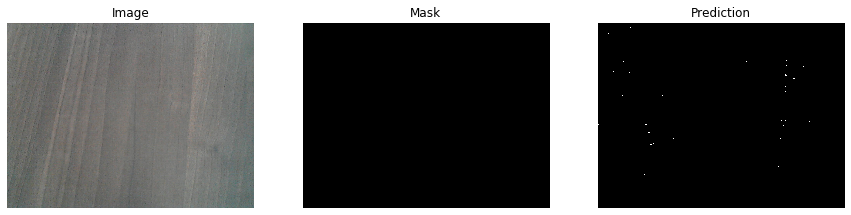

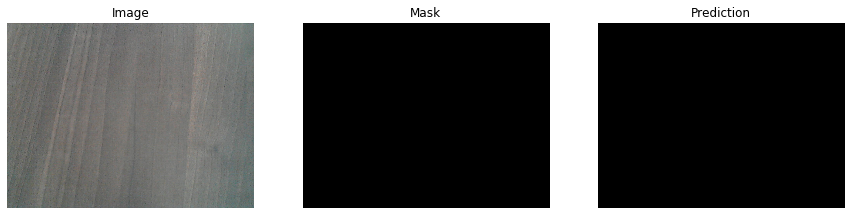

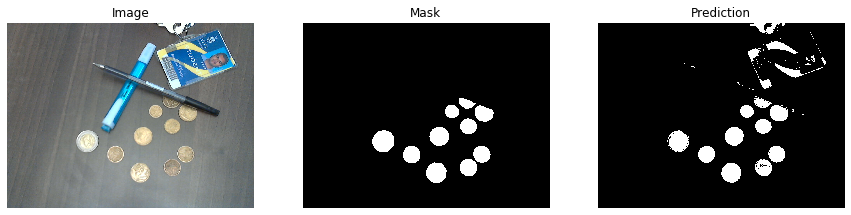

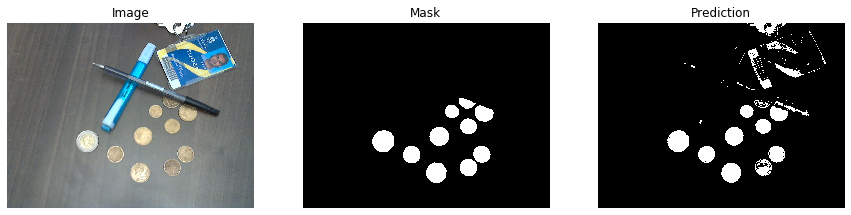

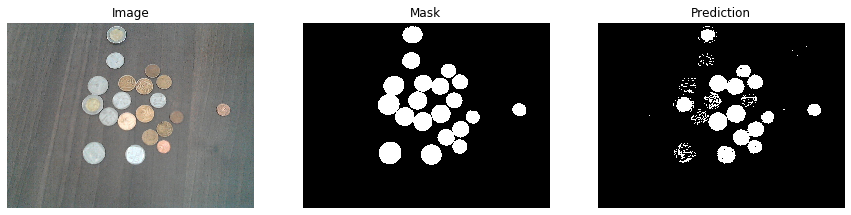

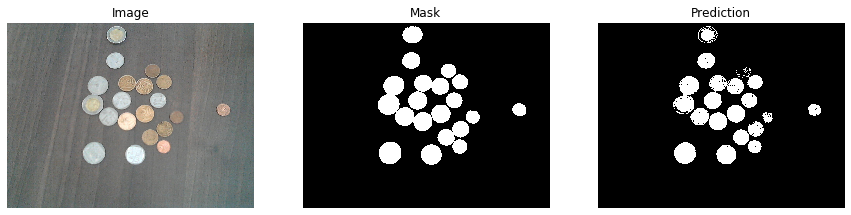

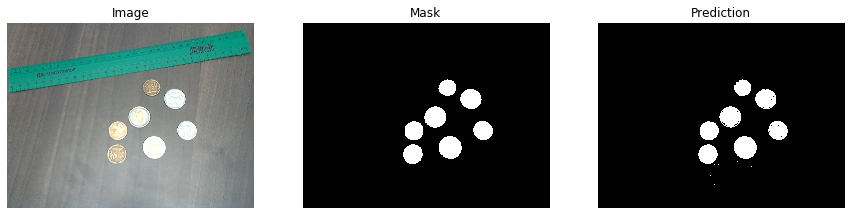

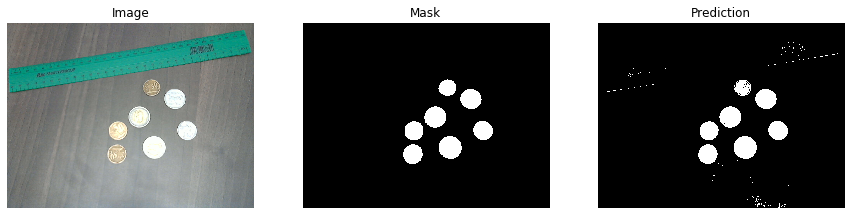

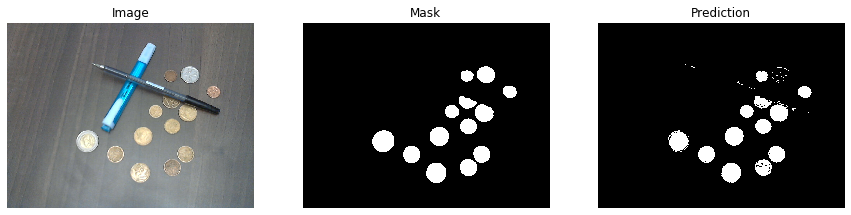

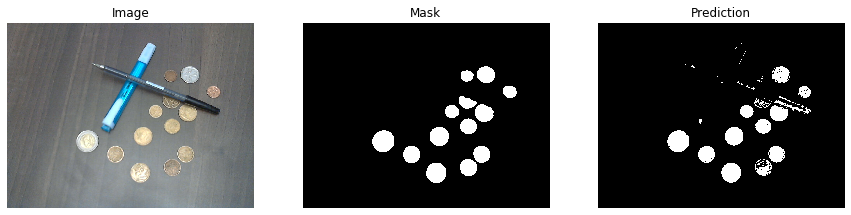

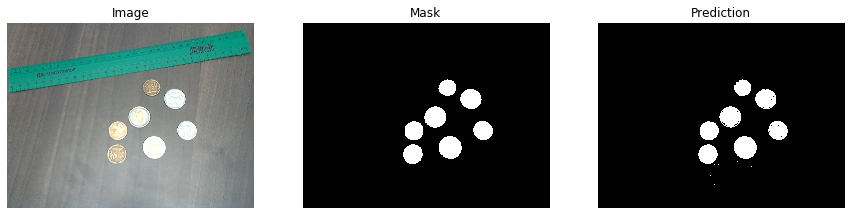

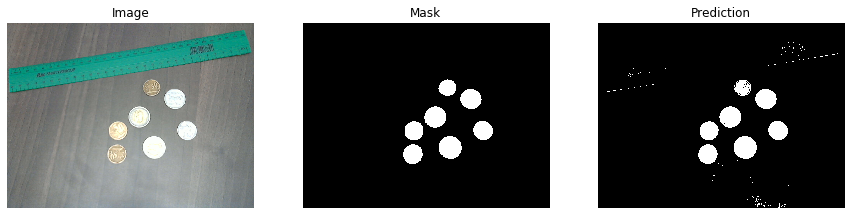

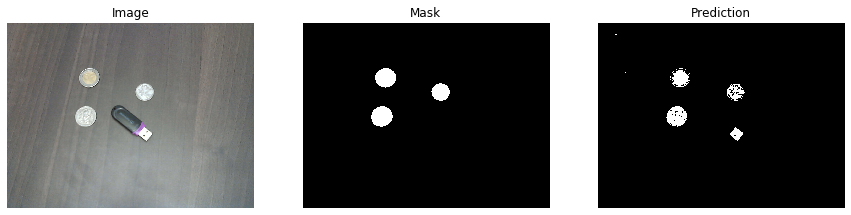

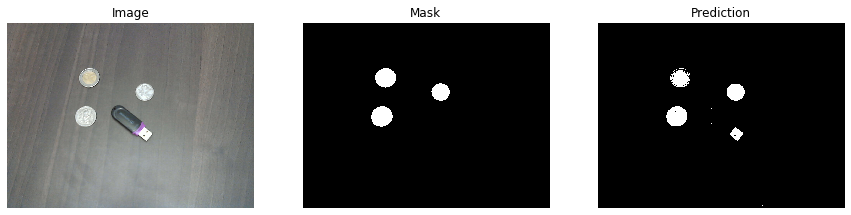

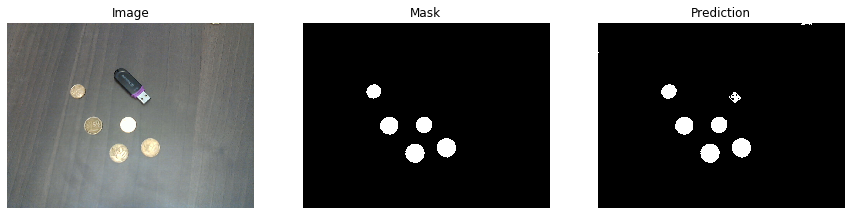

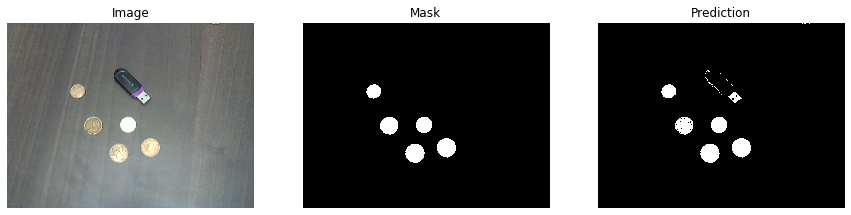

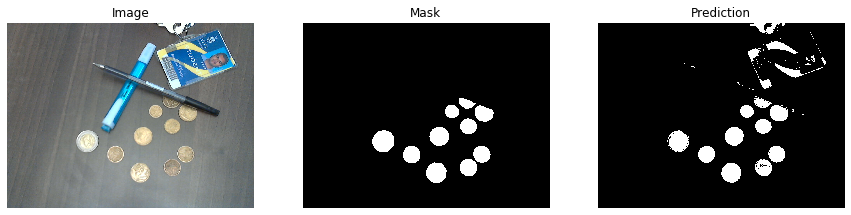

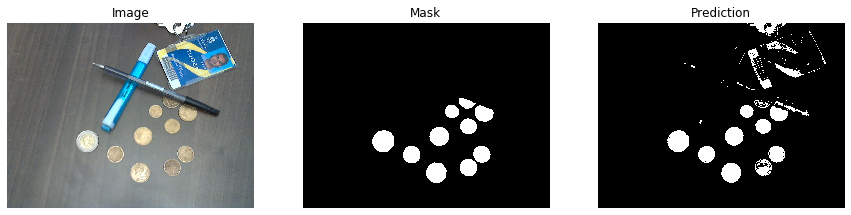

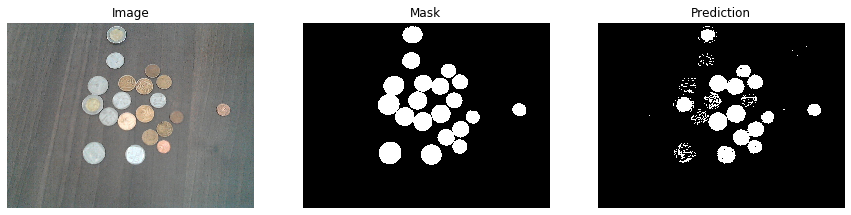

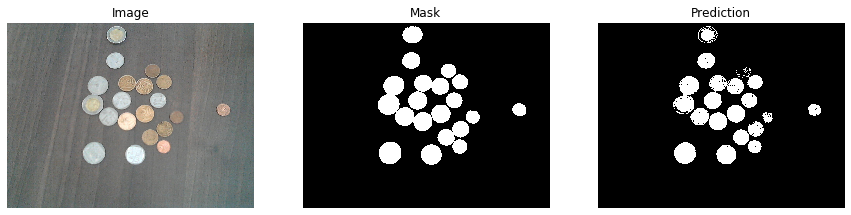

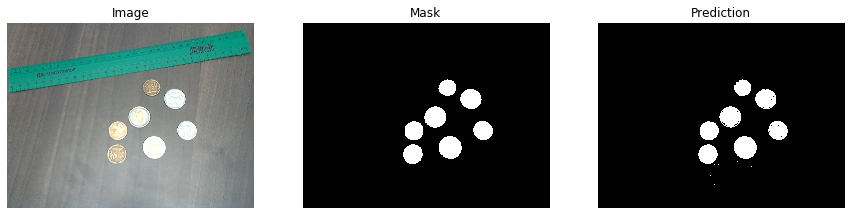

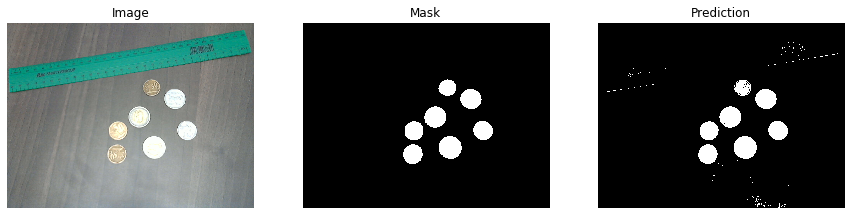

In [31]:
test_(train_images, mask_images, GMM_c[0], GMM_d[5], GMM_c[7], GMM_d[0])

In [63]:
[print(GMM_c[5].covs[i]) for i in range(GMM_c[5].n)]

[[ 426.59383838   36.91536112 -270.72132155]
 [  36.91536112   12.99038602  -53.40837729]
 [-270.72132155  -53.40837729  863.24652118]]
[[ 256.51044998  -22.62783345 -138.93775375]
 [ -22.62783345 1318.1254864  -422.60656512]
 [-138.93775375 -422.60656512  625.73093085]]
[[ 45.74107722 -45.85266377 -29.61175749]
 [-45.85266377 189.23924358  66.22448258]
 [-29.61175749  66.22448258 285.95573106]]
[[ 103.64834068   17.01439049   81.98239952]
 [  17.01439049   76.08859601  -49.11147756]
 [  81.98239952  -49.11147756 1058.73599995]]
[[ 122.67466135  -61.25442976   25.66977111]
 [ -61.25442976  169.28499005  -10.03560522]
 [  25.66977111  -10.03560522 1449.23592618]]
[[  25.56301137  -50.93339556   27.1278665 ]
 [ -50.93339556  269.50316218 -183.11800509]
 [  27.1278665  -183.11800509 1032.069773  ]]


[None, None, None, None, None, None]